# INTRODUCTION

> An electrocardiogram (ECG) is a simple test that can be used to check your heart's rhythm and electrical activity.

> Sensors attached to the skin are used to detect the electrical signals produced by your heart each time it beats. These signals are recorded by a machine and are looked at by a doctor to see if they're unusual.


The _MIT-BIH Arrhythmia Database_ contains 48 half-hour excerpts of two-channel ambulatory ECG recordings, obtained from 47 subjects studied by the BIH Arrhythmia Laboratory between 1975 and 1979. Twenty-three recordings were chosen at random from a set of 4000 24-hour ambulatory ECG recordings collected from a mixed population of inpatients (about 60%) and outpatients (about 40%) at Boston's Beth Israel Hospital; the remaining 25 recordings were selected from the same set to include less common but clinically significant arrhythmias that would not be well-represented in a small random sample.

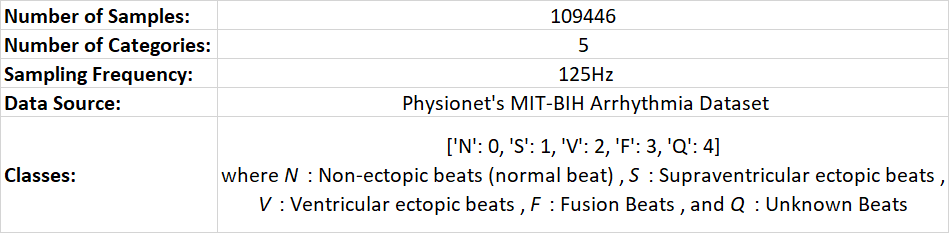

> **Ectopic heartbeats** are extra heartbeats that occur just before a regular beat. Ectopic beats are normal and usually not a cause for concern, though they can make people feel anxious.

In [ ]:
import numpy as np, pandas as pd
import tensorflow as tf, matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.utils import resample
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#        print(os.path.join(dirname, filename))
        pass

# DATA DISTRIBUTION INFO

> ptbdb_abnormal.shape => 10506x188

> ptbdb_normal.shape   => 4046x188

> mitbih_train.shape   => 87554x188

> mitbih_test.shape    => 21892x188


Normalization is not required, datasets are already normalized; if it was, we could've used:

> minmaxpreprocessor=preprocessing.MinMaxScaler()

> norm_full_train_x=pd.DataFrame(minmaxpreprocessor.fit_transform(full_train_x))

In [ ]:
''' Read the CSV file datasets: NORMAL_LABEL=0 , ABNORMAL_LABEL=1,2,3,4,5 '''
ptbdb_abnormal=pd.read_csv(os.path.join('/kaggle/input/heartbeat', 'ptbdb_abnormal.csv'),header=None)
ptbdb_normal=pd.read_csv(os.path.join('/kaggle/input/heartbeat', 'ptbdb_normal.csv'),header=None)
ptbdb_train=pd.concat([ptbdb_abnormal,ptbdb_normal],ignore_index=True)
mitbih_train=pd.read_csv(os.path.join('/kaggle/input/heartbeat', 'mitbih_train.csv'),header=None)
mitbih_test=pd.read_csv(os.path.join('/kaggle/input/heartbeat', 'mitbih_test.csv'),header=None)


'''VISUALIZE THE [MITBIH_TRAIN] DATASET: You will observe that majority of the obsvns are of Label=0'''
fig,ax=plt.subplots(figsize=(8,8))
mitbih_train[187].value_counts().plot(ax=ax,kind='bar')
plt.show()


full_train=pd.concat([mitbih_train,ptbdb_train],ignore_index=True)
full_train.shape      #102106*188

'''BREAK DOWN THE FULL TRAIN DATASET INTO X & Y'''
full_train_y=full_train[187]
full_train_x=full_train.drop(columns=[187])

'''BREAK DOWN THE TEST DATASET INTO X & Y'''
mitbih_test_y=mitbih_test[187]
mitbih_test_x=mitbih_test.drop(columns=[187])

In [ ]:
'''TO VISUALIZE TRAINING LABEL-WISE DISTRIBUTION OF DATA IN PIE-CHART'''
plt.figure(figsize=(10,10))
plt.pie(mitbih_train[187].value_counts(), labels=['N','Q','V','S','F'],
        colors=['orange','yellow','lightblue','lightgreen','grey'], autopct='%.2f%%')
plt.gcf().gca().add_artist(plt.Circle((0,0),0.7,color='white'))
plt.title('Imbalanced classes with majority Normal heartbeats')
plt.show()

# VISUALIZING AN EXAMPLE OF EACH ECG CLASS
Curious to observe each entry of the 5 types of heartbeats.

In [ ]:
plots= [['Normal Beat','Supraventricular Ectopic Beat'], ['Ventricular Ectopic Beat', 'Fusion Ectopic Beat'], ['Unknown']]
colors= [['green', 'orange'], ['red', 'blue'], ['grey']]
fig, axs = plt.subplots(3, 2, constrained_layout=True, figsize=(14,14))
fig.delaxes(axs[2,1])

for i in range(0,5,2):
    j=i//2
    axs[j][0].plot(mitbih_train[mitbih_train[187]==i%5].sample(1, random_state=100).iloc[0,:186], colors[j][0])
    axs[j][0].set_title('{}. {}'.format(i%5,plots[j][0]))
    
    if i%5!=4:
        axs[j][1].plot(mitbih_train[mitbih_train[187]==(i%5)+1].sample(1, random_state=100).iloc[0,:186], colors[j][1])
        axs[j][1].set_title('{}. {}'.format(i%5+1,plots[j][1]))

# UPSAMPLING TO ENSURE EVEN CLASS-DISTRIBUTION
As you can observe in the above class-wise data distribution, 'N' has the highest number of records, with very few records for 'F' class.

We can use the _sklearn **resample()**_ function to upsample the other classes to bring them up to keel.

In [ ]:
'''RESAMPLING THE CLASSES TO HAVE EQUAL DATA DISTRIBUTION LED TO WORSEN PERFORMANCE (POSSIBLE UNDERFITTING REASON)'''
df0=mitbih_train[mitbih_train[187]==0].sample(n=20000,random_state=10)
df1=mitbih_train[mitbih_train[187]==1]
df2=mitbih_train[mitbih_train[187]==2]
df3=mitbih_train[mitbih_train[187]==3]
df4=mitbih_train[mitbih_train[187]==4]

df1_upsampled=resample(df1,replace=True,n_samples=20000,random_state=100)
df2_upsampled=resample(df2,replace=True,n_samples=20000,random_state=101)
df3_upsampled=resample(df3,replace=True,n_samples=20000,random_state=102)
df4_upsampled=resample(df4,replace=True,n_samples=20000,random_state=103)
train_df=pd.concat([df1_upsampled,df2_upsampled,df3_upsampled,df4_upsampled,df0])

print(train_df[187].value_counts())
plt.figure(figsize=(10,10))
plt.pie(train_df[187].value_counts(), labels=['N','Q','V','S','F'],
        colors=['orange','yellow','lightblue','lightgreen','grey'], autopct='%.2f%%')
plt.gcf().gca().add_artist(plt.Circle( (0,0), 0.7, color='white' ))
plt.title('Balanced classes after upsampling')
plt.show()

# CREATING THE MODEL BY STACKING UP CONV1D LAYERS
The following code-cell will implement a simple Sequential TFv2 model with stacked up Convolutional layers.

These will essentially summarize chunks of data together based on filter-size, to produce feature-maps.

Finally we'll have a softmax output layer to give 5 predictictions since we have 5 classes.

In [ ]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Convolution1D(filters=50,kernel_size=20,activation='relu',kernel_initializer='glorot_uniform',input_shape=(187,1)))
#a1_0=> 187-20+1= 168,50
model.add(tf.keras.layers.MaxPool1D(pool_size=10,data_format='channels_first'))
#a1_1=> 50//10= 168,5
model.add(tf.keras.layers.Convolution1D(filters=20,kernel_size=15,activation='relu',kernel_initializer='glorot_uniform'))
#a2_0=> 168-15+1= 154,20
model.add(tf.keras.layers.MaxPool1D(pool_size=15,data_format='channels_first'))
#a2_1=> 20//15= 154,1
model.add(tf.keras.layers.Convolution1D(filters=10,kernel_size=10,activation='relu',kernel_initializer='glorot_uniform'))
#a3_0=> 154-10+1=145,10
model.add(tf.keras.layers.MaxPool1D(pool_size=10,data_format='channels_first'))
#a3_1=> 10//10=145,1
model.add(tf.keras.layers.Flatten())
#a4=> 145
model.add(tf.keras.layers.Dense(units=512,activation='relu',kernel_initializer='glorot_uniform'))
#a4=> 512
model.add(tf.keras.layers.Dense(units=128,activation='relu',kernel_initializer='glorot_uniform'))
#a5=> 128
model.add(tf.keras.layers.Dense(units=5,activation='softmax'))

model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['acc'])
model.summary()

# TRAINING THE MODEL
### BALANCED DATASET

In [ ]:
mitbih_test_x2=np.asarray(mitbih_test_x)
mitbih_test_x2=mitbih_test_x2.reshape(-1,187,1)


''' DATASET AFTER UPSAMPLING, WITH EVEN DISTRIBUTION ACROSS CLASSES '''
train_df_X=np.asarray(train_df.iloc[:,:187]).reshape(-1,187,1)
train_df_Y=train_df.iloc[:,187]
print(train_df_X.shape)


hist=model.fit(train_df_X,train_df_Y,batch_size=64,epochs=20)

In [ ]:
_,acc=model.evaluate(mitbih_test_x2,mitbih_test_y,verbose=2)
print('Accuracy for the balanced-dataset = ',round(acc*100,2),'%')

# TRAINING THE MODEL - II
### UNBALANCED DATASET

In [ ]:
''' UNBALANCED TRAIN DATASET FED INTO MODEL '''
full_train_x2=np.asarray(full_train_x)
full_train_x2=full_train_x2.reshape(-1,187,1)
print(full_train_x2.shape)

hist=model.fit(full_train_x2,full_train_y,batch_size=64,epochs=20)

In [ ]:
_,acc=model.evaluate(mitbih_test_x2,mitbih_test_y,verbose=2)
print('Accuracy for the unbalanced-dataset = ',round(acc*100,2),'%')

# ROOT CAUSE ANALYSIS OF THE VALIDATION SCORE DISCREPANCY
It seems the test-dataset of _mitbih database_ performed better on the unbalanced dataset, rather than our standardized balanced dataset.

This might be because of unbalanced class-distribution even in the test-dataset, as we observed in the train-dataset. Let's find out !

In [ ]:
dist=mitbih_test[187].value_counts()
plt.figure(figsize=(10,10))
plt.pie(x=dist, labels=['N','Q','V','S','F'], colors=['orange','yellow','lightblue','lightgreen','grey'], autopct='%0.2f%%')
plt.gcf().gca().add_artist(plt.Circle(xy=(0,0), radius=0.5, color='white'))
plt.show()

# OBSERVATION
The test-accuracy is slightly lower for the unbalanced-dataset than the balanced-dataset, likely because the test-dataset itself has imbalanced class-distribution.